In [1]:
from gates import *
from states import *
from measurements import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import cma

Done


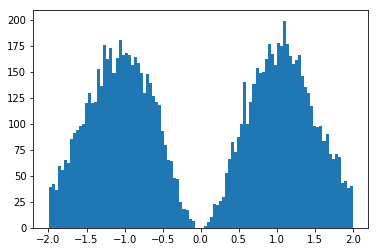

In [2]:
n_photons = 3
state1 = np.zeros(n_photons)
state1[0] = 1.
state2 = np.zeros(n_photons)
state2[0] = 1.
state3 = np.zeros(n_photons)
state3[1] = 1.
state = np.kron(state2, state3)
state = np.kron(state1, state)
data = meas_X_theta(state, 0., 3, n_photons)
plt.hist(data[:,2], bins=100)
print('Done')

# Initialization

In [3]:
n_photons = 10
num_layers = 5
# 1
vacuum_state1 = np.zeros(n_photons)
vacuum_state1[0] = 1.
init_state = vacuum_state1

In [4]:
init_state

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
def circuit(state, params, n_photons):
    state_ = state
    for i in range(num_layers):
        gate5 = N_phase_gate(params[4*i], 4, 1, 1, n_photons) 
        gate4 = D_gate(params[4*i+1], params[4*i+2], 1, 1, n_photons)
        gate3 = R_gate(params[4*i+3], 1, 1, n_photons) 
        gate2 = S_gate(params[7*i+4], params[7*i+5], 1, 1, n_photons)
        gate1 = R_gate(params[7*i+6], 1, 1, n_photons)
        state_ = np.einsum('jk,k->j', gate1, state_)
        state_ = np.einsum('jk,k->j', gate2, state_)
        state_ = np.einsum('jk,k->j', gate3, state_)
        state_ = np.einsum('jk,k->j', gate4, state_)
        state_ = np.einsum('jk,k->j', gate5, state_)
    data = sim_mes_xp(state_, 1, n_photons)
    return data[:,0], data[:,1], state_

def loss_xy(x1, p1):
    H = np.zeros(x1.shape[0], dtype=np.float32)
    dimension = x1.shape[0]
    H = (x1**2/2. + p1**2/2. - 3/2.)**2
    return np.mean(H) + np.std(H)

In [6]:
def func_to_opt(params):
    X, P, _ = circuit(init_state, params, n_photons)
    return loss_xy(X, P)

In [7]:
init_params = np.random.uniform(size=7*num_layers)
es = cma.CMAEvolutionStrategy(7*num_layers*[0.], 0.4)

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 35 (seed=327059, Tue Jan 28 10:29:14 2020)


In [ ]:
es.optimize(func_to_opt,iterations=1000)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 1.383961894258302e+00 1.0e+00 3.75e-01  4e-01  4e-01 0:47.9
    2     28 1.482837006138110e+00 1.1e+00 3.60e-01  4e-01  4e-01 1:29.9
    3     42 1.334259383914399e+00 1.1e+00 3.52e-01  3e-01  4e-01 2:10.8
    4     56 1.387004129799356e+00 1.1e+00 3.51e-01  3e-01  4e-01 2:55.0
    5     70 1.405362741519730e+00 1.1e+00 3.51e-01  3e-01  4e-01 3:40.6
    6     84 1.468690974421577e+00 1.1e+00 3.53e-01  3e-01  4e-01 4:25.4
    7     98 1.378985532459114e+00 1.1e+00 3.50e-01  3e-01  4e-01 5:16.0
    8    112 1.397786954363639e+00 1.2e+00 3.47e-01  3e-01  4e-01 5:57.7
    9    126 1.377302489726450e+00 1.2e+00 3.47e-01  3e-01  4e-01 6:42.8
   10    140 1.439600858052311e+00 1.2e+00 3.47e-01  3e-01  4e-01 7:34.0
   11    154 1.361295013348236e+00 1.2e+00 3.46e-01  3e-01  4e-01 8:19.1


In [ ]:
params = es.result_pretty().xbest
final_state = circuit(init_state, params, n_photons)[2]

In [ ]:
print(*final_state)

In [ ]:
params

In [ ]:
# 1
vacuum_state1 = np.zeros(n_photons)
vacuum_state1[1] = 1.
target_state = vacuum_state1
data = sim_mes_xp(target_state, 1, n_photons)
print('final wanted loss ------- ', loss_xy(data[:,0], data[:, 1]))

In [ ]:
final_state = final_state.reshape(final_state.shape[0], 1)
target_state = target_state.reshape(target_state.shape[0], 1)
rho = final_state @ final_state.conj().T
rho_target = target_state @ target_state.conj().T
fidelity(rho, rho_target)